In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, roc_curve, auc

In [7]:
df = pd.read_csv('customer_churn_data.csv')
print(df.head())
print(df.describe())

# here i calcualte the churn rates across the different contract types..
churn_by_contract = df.groupby('contract_length')['churned'].mean()
print(churn_by_contract.head())

   tenure_months  monthly_charges  total_usage_gb  customer_service_calls  \
0            7.0           179.42           -65.0                    -8.0   
1           52.0            88.84            91.0                    -3.0   
2           24.0            84.15            43.0                     0.0   
3           26.0            21.82           228.0                    -1.0   
4            3.0            92.24           144.0                     0.0   

   payment_delay_months contract_length  services_count  satisfaction_score  \
0                   5.0          2-Year             2.0                 5.0   
1                   1.0          1-Year             1.0                 5.0   
2                   3.0          2-Year             1.0                 5.0   
3                   4.0          1-Year             2.0                 3.0   
4                   2.0         Monthly             3.0                 1.0   

   churned  
0        0  
1        0  
2        0  
3        0

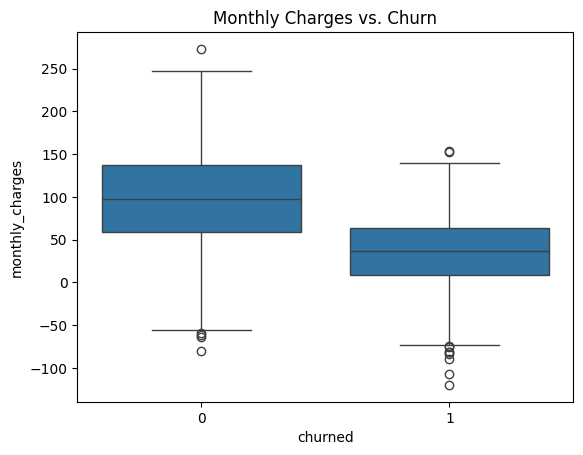

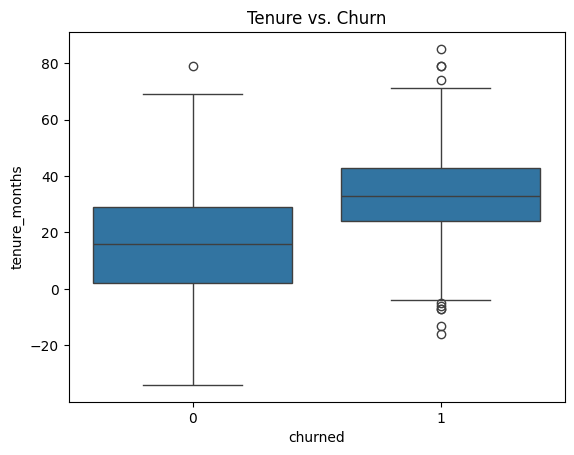

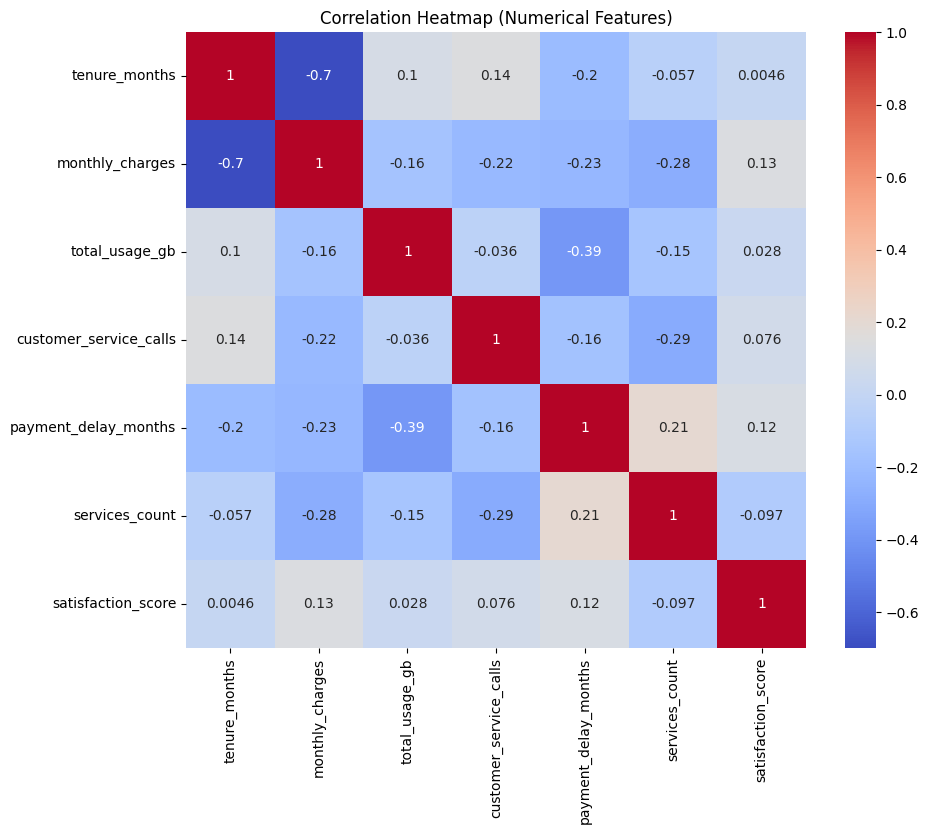

In [ ]:
sns.boxplot(x='churned', y='monthly_charges', data=df)
plt.title('Monthly Charges vs. Churn')
plt.show()

sns.boxplot(x='churned', y='tenure_months', data=df)
plt.title('Tenure vs. Churn')
plt.show()

numerical_features = ['tenure_months', 'monthly_charges', 'total_usage_gb', 
                      'customer_service_calls', 'payment_delay_months', 'services_count', 
                      'satisfaction_score']

# Calculate the correlation matrix for numerical features
# here i just calculate the correlation matrix for just numerical vallues
plt.figure(figsize=(10, 8))
sns.heatmap(df[numerical_features].corr(), annot=True, cmap='coolwarm')
plt.title('Correlation Heatmap (Numerical Features)')
plt.show()

In [13]:
df['average_monthly_usage'] = df['total_usage_gb'] / df['tenure_months']
df['customer_value_score'] = df['monthly_charges'] * df['tenure_months']
df['risk_score'] = df['payment_delay_months'] + df['customer_service_calls']
print(df.head())

   tenure_months  monthly_charges  total_usage_gb  customer_service_calls  \
0            7.0           179.42           -65.0                    -8.0   
1           52.0            88.84            91.0                    -3.0   
2           24.0            84.15            43.0                     0.0   
3           26.0            21.82           228.0                    -1.0   
4            3.0            92.24           144.0                     0.0   

   payment_delay_months contract_length  services_count  satisfaction_score  \
0                   5.0          2-Year             2.0                 5.0   
1                   1.0          1-Year             1.0                 5.0   
2                   3.0          2-Year             1.0                 5.0   
3                   4.0          1-Year             2.0                 3.0   
4                   2.0         Monthly             3.0                 1.0   

   churned  average_monthly_usage  customer_value_score  risk_

In [18]:
features = ['tenure_months', 'monthly_charges', 'contract_length', 'average_monthly_usage', 
            'customer_value_score', 'risk_score', 'services_count', 'satisfaction_score']
target = 'churned'

X = df[features]
y = df[target]

encoder = OneHotEncoder(handle_unknown='ignore')
encoded_features = encoder.fit_transform(X[['contract_length']]).toarray()
encoded_df = pd.DataFrame(encoded_features)
X = X.drop('contract_length', axis=1)
X = pd.concat([X, encoded_df], axis=1)

X.columns = X.columns.astype(str) 

X = np.nan_to_num(X, posinf=1e10, neginf=-1e10)


scaler = StandardScaler()
X = scaler.fit_transform(X)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

model = LogisticRegression()
model.fit(X_train, y_train)

y_pred = model.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)

print(f'accuracy: {accuracy}')
print(f'precision: {precision}')
print(f'recall: {recall}')

accuracy: 0.76
precision: 0.7327586206896551
recall: 0.8333333333333334


Logistic Regression - Cross-validation ROC AUC: 0.8084808480848086
Random Forest - Cross-validation ROC AUC: 0.8965196519651965
XGBoost - Cross-validation ROC AUC: 0.8816281628162816


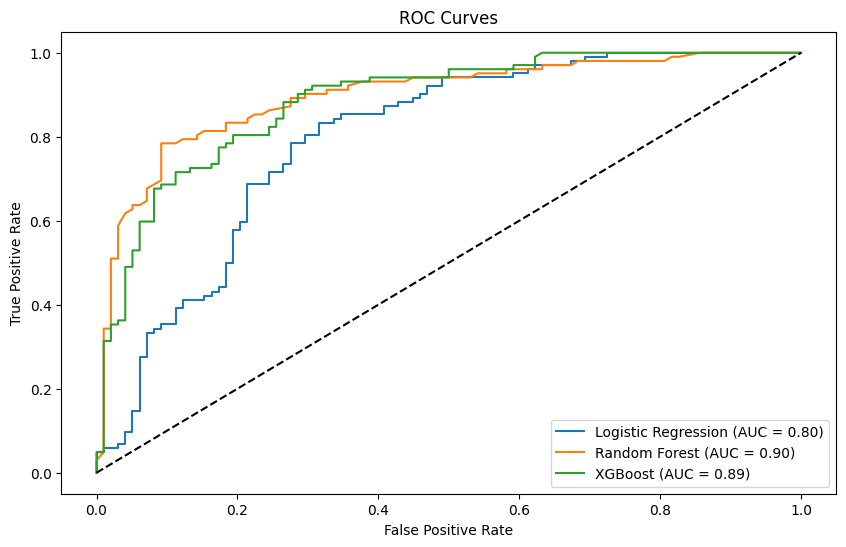

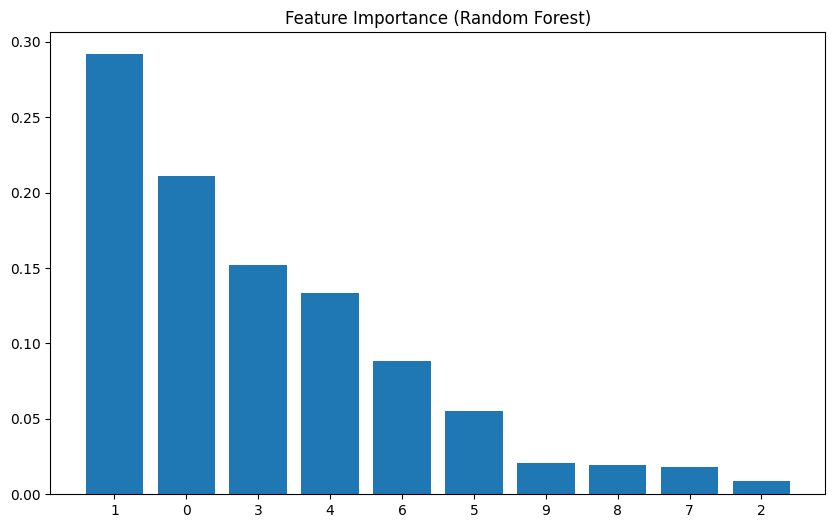

In [19]:
models = {
    'Logistic Regression': LogisticRegression(),
    'Random Forest': RandomForestClassifier(),
    'XGBoost': GradientBoostingClassifier()
}
# just created the dictionary for easier accessc

for name, model in models.items():
    cv_scores = cross_val_score(model, X, y, cv=5, scoring='roc_auc')
    print(f'{name} - Cross-validation ROC AUC: {np.mean(cv_scores)}')

plt.figure(figsize=(10, 6))
for name, model in models.items():
    model.fit(X_train, y_train)
    y_probs = model.predict_proba(X_test)[:, 1]
    fpr, tpr, thresholds = roc_curve(y_test, y_probs)
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, label=f'{name} (AUC = {roc_auc:.2f})')

plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curves')
plt.legend(loc='lower right')
plt.show()

rf_model = RandomForestClassifier()
rf_model.fit(X_train, y_train)
importances = rf_model.feature_importances_
indices = np.argsort(importances)[::-1]

plt.figure(figsize=(10, 6))
plt.title("Feature Importance (Random Forest)")
plt.bar(range(X_train.shape[1]), importances[indices])
plt.xticks(range(X_train.shape[1]), indices)
plt.show()